In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'cirrhosis.csv'
df = pd.read_csv(file_path)

# Show first few rows
display(df.head())

# Show basic info
print('Shape:', df.shape)
df.info()

# Show missing values per column
print('\nMissing values per column:')
print(df.isnull().sum())

# Show summary statistics
display(df.describe(include='all'))

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


Shape: (418, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float6

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418,312,418.000000,418,312,312,312,418,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
unique,NaN,NaN,3,2,NaN,2,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,C,D-penicillamine,NaN,F,N,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,232,158,NaN,374,288,160,222,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,209.500000,1917.782297,NaN,NaN,18533.351675,NaN,NaN,NaN,NaN,NaN,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,120.810458,1104.672992,NaN,NaN,3815.845055,NaN,NaN,NaN,NaN,NaN,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,1.000000,41.000000,NaN,NaN,9598.000000,NaN,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,105.250000,1092.750000,NaN,NaN,15644.500000,NaN,NaN,NaN,NaN,NaN,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,209.500000,1730.000000,NaN,NaN,18628.000000,NaN,NaN,NaN,NaN,NaN,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,313.750000,2613.500000,NaN,NaN,21272.500000,NaN,NaN,NaN,NaN,NaN,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000


In [3]:
# Handle missing values
# For categorical columns, fill with mode
categorical_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# For continuous columns, fill with median
continuous_cols = ['Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
for col in continuous_cols:
    df[col] = df[col].fillna(df[col].median())

# Check again for missing values
print('Missing values after imputation:')
print(df.isnull().sum())

Missing values after imputation:
ID               0
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into features and label
y = df['Status']
X = df.drop(['Status', 'ID'], axis=1)

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (334, 18)
Test set shape: (84, 18)


In [5]:
# Show feature types
feature_types = pd.DataFrame({'Feature': X_train.columns,
                              'Type': X_train.dtypes})

# Identify categorical and continuous features
categorical_features = feature_types[feature_types['Type'] == 'object']['Feature'].tolist()
continuous_features = feature_types[feature_types['Type'] != 'object']['Feature'].tolist()

print('Categorical features:', categorical_features)
print('Continuous features:', continuous_features)

feature_types['Category'] = feature_types['Feature'].apply(lambda x: 'Categorical' if x in categorical_features else 'Continuous')
display(feature_types)

Categorical features: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
Continuous features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


,Feature,Type,Category
N_Days,N_Days,int64,Continuous
Drug,Drug,object,Categorical
Age,Age,int64,Continuous
Sex,Sex,object,Categorical
Ascites,Ascites,object,Categorical
Hepatomegaly,Hepatomegaly,object,Categorical
Spiders,Spiders,object,Categorical
Edema,Edema,object,Categorical
Bilirubin,Bilirubin,float64,Continuous
Cholesterol,Cholesterol,float64,Continuous


In [6]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]), columns=encoder.get_feature_names_out(categorical_features), index=X_train.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]), columns=encoder.get_feature_names_out(categorical_features), index=X_test.index)

# Drop original categorical columns and concatenate encoded columns
X_train_final = pd.concat([X_train.drop(categorical_features, axis=1), X_train_encoded], axis=1)
X_test_final = pd.concat([X_test.drop(categorical_features, axis=1), X_test_encoded], axis=1)

print('Encoded training set shape:', X_train_final.shape)
print('Encoded test set shape:', X_test_final.shape)

Encoded training set shape: (334, 19)
Encoded test set shape: (84, 19)


Label distribution (counts):
Status
C     185
D     129
CL     20
Name: count, dtype: int64

Label distribution (percent):
Status
C     55.389222
D     38.622754
CL     5.988024
Name: proportion, dtype: float64


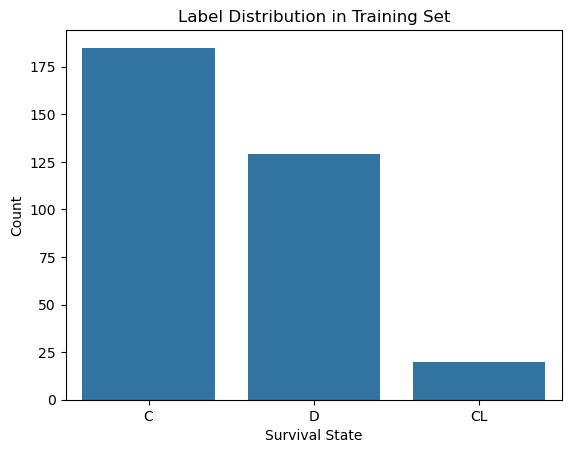

The training set is imbalanced.


In [7]:
# Show label distribution in training data
label_counts = y_train.value_counts()
label_percent = y_train.value_counts(normalize=True) * 100
print('Label distribution (counts):')
print(label_counts)
print('\nLabel distribution (percent):')
print(label_percent)

# Visualize label distribution
sns.countplot(x=y_train)
plt.title('Label Distribution in Training Set')
plt.xlabel('Survival State')
plt.ylabel('Count')
plt.show()

# Is the training set balanced?
if label_percent.min() < 20:
    print('The training set is imbalanced.')
else:
    print('The training set is relatively balanced.')

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Validation method: Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='f1_weighted')
    results[name] = scores
    print(f'{name} F1 (weighted) CV scores:', scores)
    print(f'{name} Mean F1 (weighted): {scores.mean():.4f}\n')

# Fit models and report test performance
for name, model in models.items():
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    print(f'--- {name} Test Performance ---')
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Weighted F1: {f1_score(y_test, y_pred, average="weighted"):.4f}\n')

c:\Users\micha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\micha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

Logistic Regression F1 (weighted) CV scores: [0.69766552 0.7249467  0.74829068 0.68198579 0.71788259]
Logistic Regression Mean F1 (weighted): 0.7142

Random Forest F1 (weighted) CV scores: [0.73670111 0.75249484 0.71985369 0.71664747 0.71877677]
Random Forest Mean F1 (weighted): 0.7289

Random Forest F1 (weighted) CV scores: [0.73670111 0.75249484 0.71985369 0.71664747 0.71877677]
Random Forest Mean F1 (weighted): 0.7289



ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\micha\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\micha\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\micha\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1640, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['C' 'CL' 'D']
